In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.weightstats import ztest
import seaborn as sns
from scipy import stats as sts
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Проверка гипотез

In [2]:
df = pd.read_csv('обработанные данные.csv')

In [3]:
#некоторые признаки, которые должны быть списками, превратились в строки, исправим
for c in ['grape', 'features', 'taste', 'dishes', 'description']:
    df[c][df[c].isnull() == False] = df[c][df[c].isnull() == False].apply(eval)

In [4]:
df.head()

,Unnamed: 0,name,w_id,href,base_price,discount_size,discount_price,simple_collection,country,color,...,dishes,sugar,acidity,aromaticity,tannins,body,description,client_rating,critic_rating,otklonenue
0,0,Вино Le Grand Noir Winemaker’s Selection Chard...,140872,/catalog/product/les_celliers_jean_d_alibert__...,1120,NaN,NaN,False,Франция,белое,...,"[Курица, Азиатская кухня, Рыба]",2.0,2.0,3.0,NaN,3.0,[ Стилистика ви...,92.0,NaN,NaN
1,1,"Вино Classic, Domaine Tariquet, 2021г.",137145,/catalog/product/domaine_tariquet_classic_2021...,1640,NaN,NaN,False,Франция,белое,...,"[Азиатская кухня, Морепродукты, Сыр]",2.0,3.0,3.0,NaN,3.0,[ Стилистика ви...,92.0,NaN,NaN
2,2,"Вино Mare & Grill Vinho Verde Rose, Quintas da...",140549,/catalog/product/mare_grill_vinho_verde_rose_2...,890,NaN,NaN,False,Португалия,розовое,...,"[Рыба, Свинина, Курица]",NaN,NaN,NaN,NaN,NaN,[ Стилистика ви...,89.0,NaN,NaN
3,3,"Вино Mare & Grill Vinho Verde, Quintas das Arc...",140407,/catalog/product/mare_grill_vinho_verde_2021_0...,890,NaN,NaN,False,Португалия,белое,...,[Морепродукты],NaN,NaN,NaN,NaN,NaN,[ Стилистика ви...,89.0,NaN,NaN
4,4,"Вино Пино Нуар Семейный Резерв, Сикоры, 2019г.",141551,/catalog/product/pino_nuar_semeynyy_rezerv_201...,3790,NaN,NaN,False,Россия,красное,...,NaN,NaN,NaN,NaN,NaN,NaN,[ Стилистика ви...,90.0,NaN,NaN


# Гипотезы 1 и 2

## Проверим гипотезы о том, что красное вино в среднем дороже, чем белое, а белое в среднем дороже, чем розовое

Построим точечные диаграммы распределения цен на красное, белое и розовое вино, чтобы зрительно оценить распределения.

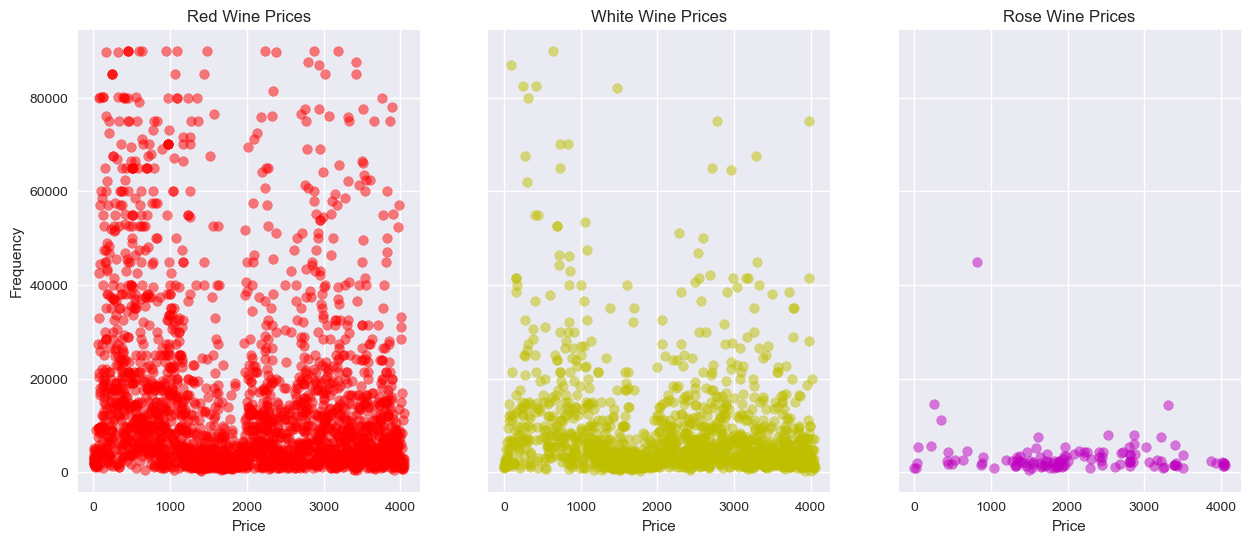

In [5]:
# Создаем три группы: красное, белое и розовое вино
red_wine = df[df['color'] == 'красное']['base_price']
white_wine = df[df['color'] == 'белое']['base_price']
rose_wine = df[df['color'] == 'розовое']['base_price']

# Создаем точечные диаграммы распределения для красного вина
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

axs[0].scatter(red_wine.index, red_wine, color='r', alpha=0.5)
axs[0].set_title('Red Wine Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

# Второй подграфик для белого вина
axs[1].scatter(white_wine.index, white_wine, color='y', alpha=0.5)
axs[1].set_title('White Wine Prices')
axs[1].set_xlabel('Price')

# Третий подграфик для розового вина
axs[2].scatter(rose_wine.index, rose_wine, color='m', alpha=0.5)
axs[2].set_title('Rose Wine Prices')
axs[2].set_xlabel('Price')

plt.show()

### Гипотеза о том, что красное вино в среднем дороже, чем белое

__Формы распределения первых двух групп схожи (красные и белые вина), однако данные не следуют нормальному распределению, используем Mann-Whitney U-тест для проверки гипотез__

_Mann-Whitney U-тест является непараметрическим тестом, что означает, что он может использоваться с выборками, которые не распределены нормально и имеют неравные дисперсии._

_Предположения, которые следует учитывать при его использовании:_
* _Независимость выборок: выборки "red_wine" и "white_wine" независимы, так как каждое отдельное вино может относиться одновременно только к одной из этих выборок._
* _Форма распределения: Mann-Whitney U-тест делает предположение, что формы распределения двух групп схожи, для выборок "red_wine" и "white_wine" это подтверждается зрительной оценкой точечные диаграммы распределения, представленных выше._

_Нулевая гипотеза для Mann-Whitney U-теста состоит в том, что медианы двух групп равны, а альтернативная гипотеза состоит в том, что медианы не равны. Если полученное p-значение меньше заданного уровня значимости (например, 0.05), то мы отвергаем нулевую гипотезу и приходим к выводу, что различия между группами статистически значимы._

__Нулевая гипотеза (H0):__ Средняя цена красного вина равна средней цене белого вина.

__Альтернативная гипотеза (H1):__ Средняя цена красного вина больше средней цены белого вина.

In [6]:
# Применяем Mann-Whitney U-тест
_, p_value = mannwhitneyu(red_wine, white_wine, alternative='greater')

print(f'p-value: {p_value}')

p-value: 1.0139484640335817e-54


__Полученное p-value значительно меньше уровня значимости (0.05), нулевая гипотеза отвергается и можно считать, что средняя цена красного вина действительно больше средней цены белого вина__

### Гипотеза о том, что белое вино в среднем дороже, чем розовое

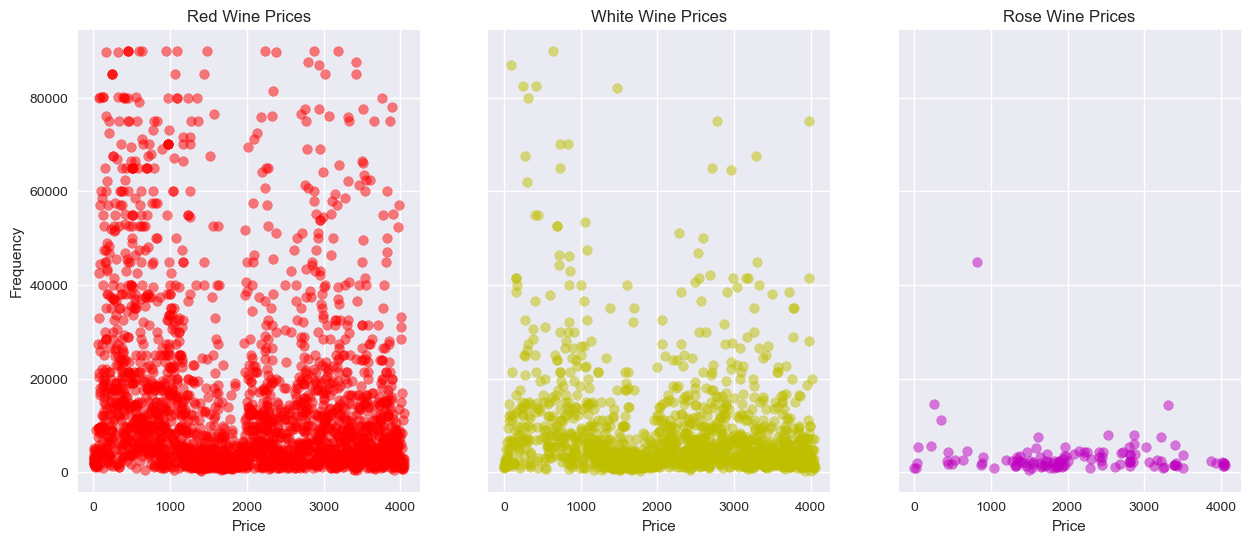

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Создаем подграфик для красного вина
axs[0].scatter(red_wine.index, red_wine, color='r', alpha=0.5)
axs[0].set_title('Red Wine Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

# Второй подграфик для белого вина
axs[1].scatter(white_wine.index, white_wine, color='y', alpha=0.5)
axs[1].set_title('White Wine Prices')
axs[1].set_xlabel('Price')

# Третий подграфик для розового вина
axs[2].scatter(rose_wine.index, rose_wine, color='m', alpha=0.5)
axs[2].set_title('Rose Wine Prices')
axs[2].set_xlabel('Price')

plt.show()

__Сложно, зрительно оценив график, сделать вывод об "одинаковости" форм распределения групп розовых и белых вин. Данные в обеих выборках не следуют нормальному распределению, используем z-тест для проверки гипотез__

_Z-тест может использоваться для проверки гипотез о средних двух независимых групп при выполнении определенных условий._ 

_Ключевые предположения для Z-теста:_
* _Независимость выборок: выборки "rose_wine" и "white_wine" независимы, так как каждое отдельное вино может относиться одновременно только к одной из этих выборок._
* _Размеры выборок должны быть большими (как правило, N > 30 для каждой выборки), также при больших выборках нормальность необязательна вследствие ЦПТ!!!_

_В случае использования Z-теста для сравнения средних двух независимых групп, нулевая гипотеза состоит в том, что средние значения двух групп равны, а альтернативная гипотеза состоит в том, что средние значения не равны. Если полученное p-значение меньше заданного уровня значимости (например, 0.05), то мы отвергаем нулевую гипотезу и приходим к выводу, что различия между группами статистически значимы._

__Нулевая гипотеза (H0):__ Средняя цена белого вина не больше средней цены белого вина.

__Альтернативная гипотеза (H1):__ Средняя цена белого вина больше средней цены розового вина.

In [8]:
# Проводим z-тест
_, p_value = ztest(white_wine, rose_wine, alternative='larger')

print(f"p-value: {p_value}")

p-value: 3.11061603961213e-07


__полученное p-value значительно меньше уровня значимости (0.05), нулевая гипотеза отвергается и можно считать, что средняя цена белого вина действительно больше средней цены розового вина__

### Таким образом, красное вино в среднем дороже, чем белое, а белое в среднем дороже, чем розовое

Визуализируем гипотезы о том, что красное вино в среднем дороже, чем белое, а белое в среднем дороже, чем розовое с помощью скрипичного графика (выбрали именно его, так как он наиболее информативен)

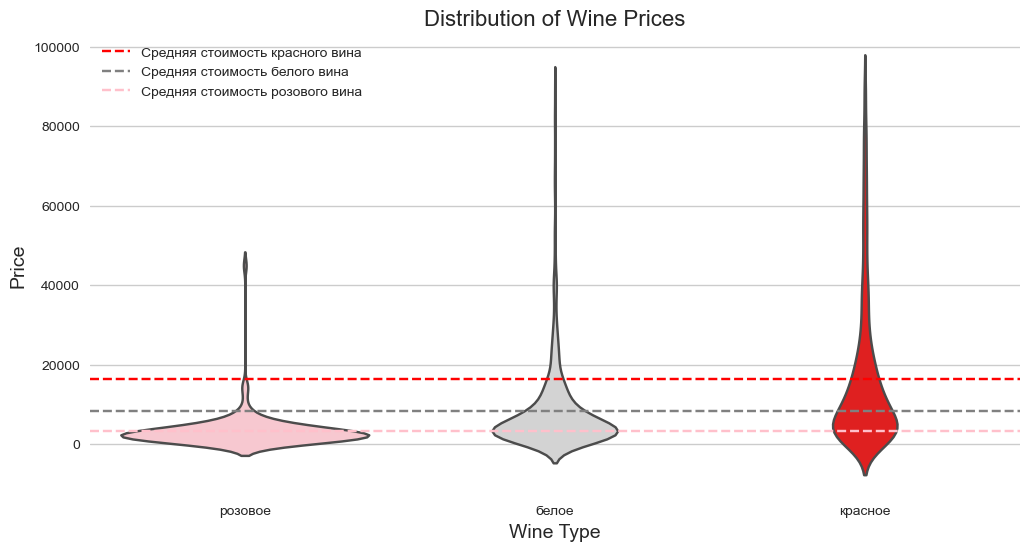

In [9]:
# Оставляем только интересующие нас типы вина
df_color = df[df['color'].isin(['красное', 'белое', 'розовое'])]

# Устанавливаем стиль и размеры
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
palette = {'розовое': 'pink', 'белое': 'lightgray', 'красное': 'red'}

# Построение скрипичного графика
sns.violinplot(x='color', y='base_price', data=df_color, order=['розовое', 'белое', 'красное'], inner=None, palette=palette)

# Построение линий средних для разных вин
plt.axhline(y=np.mean(red_wine), linestyle='--', color='red', label='Средняя стоимость красного вина')
plt.axhline(y=np.mean(white_wine), linestyle='--', color='gray', label='Средняя стоимость белого вина')
plt.axhline(y=np.mean(rose_wine), linestyle='--', color='pink', label='Средняя стоимость розового вина')

plt.title('Distribution of Wine Prices', fontsize=16)
plt.xlabel('Wine Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='upper left')
plt.show()

# Гипотезы 3 и 4

## Зададимся вопросами: можно ли доверять рейтингу критиков? Правда ли, что в критики строже оценивают вина, чем обычные клиенты?

Построим точечные диаграммы рейтинга критиков и рейтинга клиентов, чтобы зрительно оценить распределения.

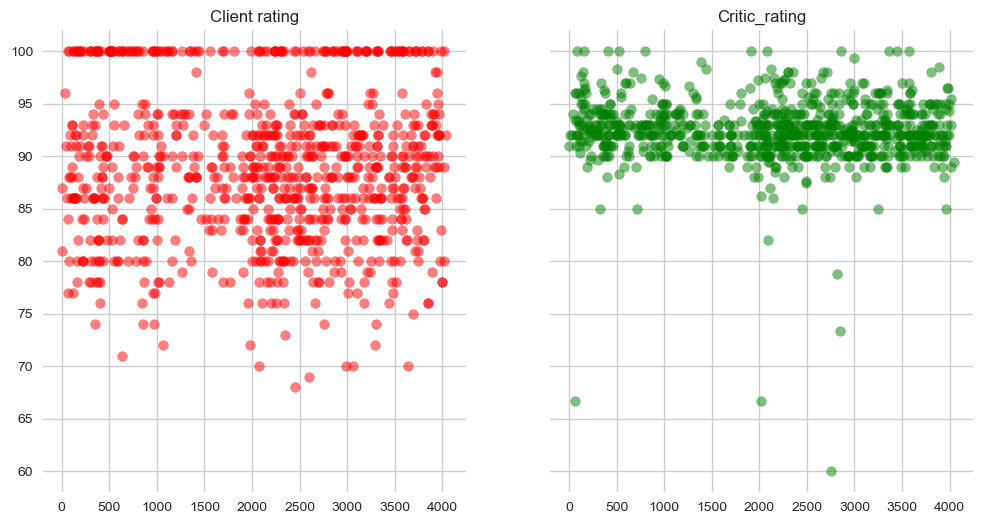

In [10]:
# Создаем две группы: рейтинг критиков и рейтинг клиентов (где есть обе оценки, где значение соответствующей ячейки не пустое)
df_ratings = df.dropna(subset=['client_rating', 'critic_rating'])
client_rating = df_ratings['client_rating']
critic_rating = df_ratings['critic_rating']

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Создаем точечные диаграммы распределения для клиентского рейтинга
axs[0].scatter(client_rating.index, client_rating, color='r', alpha=0.5)
axs[0].set_title('Client rating')

# Создаем точечные диаграммы распределения для рейтинга критиков
axs[1].scatter(critic_rating.index, critic_rating, color='g', alpha=0.5)
axs[1].set_title('Critic_rating')

plt.show()

__Формы распределения двух групп схожи, однако у них разнятся средние и дисперсии, также данные не следуют нормальному распределению.__

### Можно ли доверять рейтингу критиков?

Для ответа на этот вопрос посчитаем корреляцию между выборками client_rating и critic_rating. С помощью перестановочного теста проверим, говрит ли полученная выборочная корреляция о зависимости признаков.

__Нулевая гипотеза (H0):__ Признаки client_rating и critic_rating независимы.

__Альтернативная гипотеза (H1):__ Признаки client_rating и critic_rating зависимы.

In [11]:
import random
import numpy as np

# Сделаем из рейтингов list
client_rating = list(client_rating)
critic_rating = list(critic_rating)

# Найдем выборочную корреляцию
corr = np.corrcoef(client_rating, critic_rating)[0, 1]

# Посчитаем корреляции после перестановки
corrs = []
for _ in range(10000):
    list2_shuffled = random.sample(critic_rating, len(critic_rating))
    corr_shuffled = np.corrcoef(client_rating, list2_shuffled)[0, 1]
    corrs.append(corr_shuffled)

# Построим доверительный интервал и проверим, входит ли в него наше значение корреляции
interval = [np.percentile(corrs, 2.5), np.percentile(corrs, 97.5)]
if interval[0] <= corr <= interval[1]:
    print('H0 не отвергается на уровне значимости 0.05')
else:
    print('H0 отвергается на уровне значимости 0.05')

# Вычислим p-value
p_value = np.mean(np.array(corrs) > corr) * 2
print('P-value =', p_value)
print('Выборочная корреляция =', corr)
print('95% доверительный интервал =', interval)

H0 отвергается на уровне значимости 0.05
P-value = 0.0
Выборочная корреляция = 0.19162723198489115
95% доверительный интервал = [-0.06608240392156378, 0.06812661786493862]


_Нулевая гипотеза отвергается, следовательно, признаки client_rating и critic_rating зависимы._

__Таким образом, корреляция между рейтингом клиентов и рейтингом критиков положительна, но невелика, соответственно, клиенты оценивают вина иначе, чем критики. Обычному клиенту следует с осторожностью относиться к рейтингу критиков!__

Визуализируем гипотезу о том, критики иначе оценивают вина, чем обычные клиенты с помощью точечной диаграммы распределения

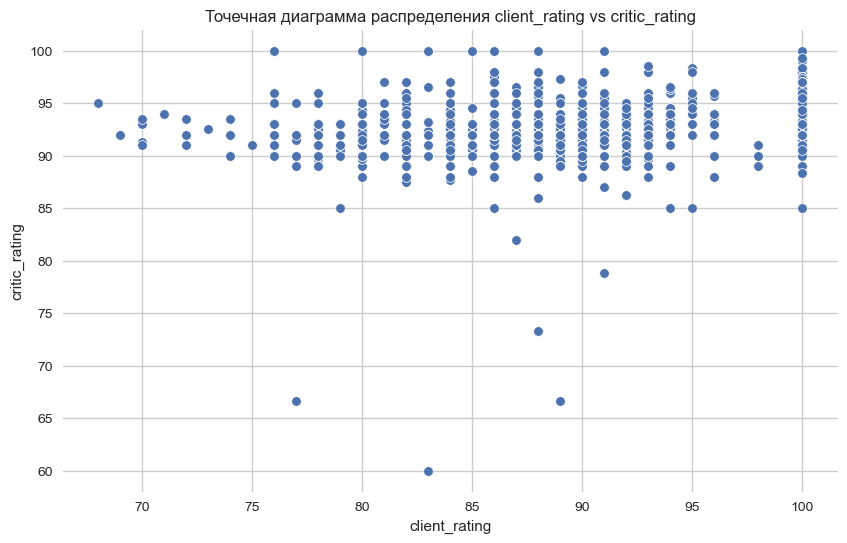

In [12]:
plt.figure(figsize=(10,6))
sns.scatterplot(client_rating, critic_rating)
plt.title('Точечная диаграмма распределения client_rating vs critic_rating')
plt.xlabel('client_rating')
plt.ylabel('critic_rating')
plt.show()

### Правда ли, что в критики строже оценивают вина, чем обычные клиенты?

Чтобы ответить на этот вопрос используем z-тест.

_Z-тест может использоваться для проверки гипотез о средних двух независимых групп при выполнении определенных условий._ 

_Ключевые предположения для Z-теста:_
* _Независимость выборок: каждая оценка критика и каждая оценка клиента представляют отдельное наблюдение и формируют независимые выборки._
* _Размеры выборок должны быть большими (как правило, N > 30 для каждой выборки), также при больших выборках нормальность необязательна вследствие ЦПТ!!!_

_В случае использования Z-теста для сравнения средних двух независимых групп, нулевая гипотеза состоит в том, что средние значения двух групп равны, а альтернативная гипотеза состоит в том, что средние значения не равны. Если полученное p-значение меньше заданного уровня значимости (например, 0.05), то мы отвергаем нулевую гипотезу и приходим к выводу, что различия между группами статистически значимы._

__Нулевая гипотеза (H0):__ Рейтинг критиков не выше рейтинга клиентов.

__Альтернативная гипотеза (H1):__ Рейтинг критиков выше рейтинга клиентов.

In [13]:
# Проводим z-тест
_, p_value = ztest(critic_rating, client_rating, alternative='larger')

print(f"p-value: {p_value}")

p-value: 7.047034725872022e-45


__полученное p-value значительно меньше уровня значимости (0.05), нулевая гипотеза отвергается и можно считать, что средний рейтинг критиков выше среднего клиентского рейтинга__

## Таким образом, обычным клиентам не стоит однозначно доверять рейтингу критиков (клиенты оценивают вина иначе, чем критики), и критики выше оценивают вина, чем обычные клиенты

Визуализируем гипотезу о том, критики строже оценивают вина, чем обычные клиенты с помощью скрипичного графика (выбрали именно его, так как он наиболее информативен)

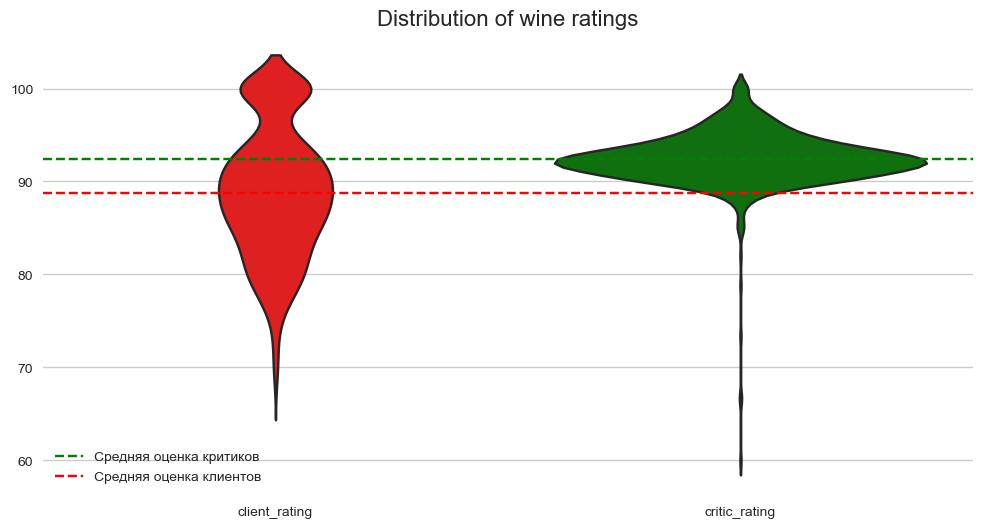

In [14]:
# Устанавливаем стиль и размеры
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
palette = {'client_rating': 'r', 'critic_rating': 'g'}

# Построение скрипичного графика
sns.violinplot(data=df_ratings, order=['client_rating', 'critic_rating'], inner=None, palette=palette)

# Построение линий средних для оценок критиков и клиентов
plt.axhline(y=np.mean(critic_rating), linestyle='--', color='green', label='Средняя оценка критиков')
plt.axhline(y=np.mean(client_rating), linestyle='--', color='red', label='Средняя оценка клиентов')

plt.title('Distribution of wine ratings', fontsize=16)
plt.legend(loc='lower left')
plt.show()

# Гипотезы 5 и 6

## Проверю гипотезы о том, что сухое вино в среднем дороже, чем полусухое, а сладкое в среднем дороже, чем полусладкое

### Гипотеза о том, что сухое вино в среднем дороже, чем полусухое

Построим гистограммы распределения цен на сухое и полусухое вино, чтобы зрительно оценить распределения.

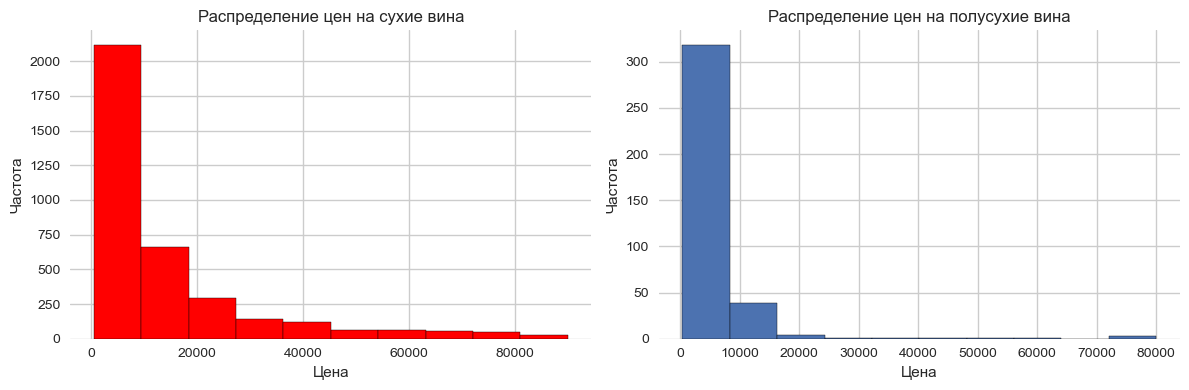

In [15]:
dry_wine = df[df['sweetness'] == 'сухое']['base_price']
semi_dry_wine = df[df['sweetness'] == 'полусухое']['base_price']

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

# Создаем гистограмму распределения для цен на сухое вино
axes[0].hist(dry_wine, bins=10, edgecolor='black', color='r')
axes[0].set_xlabel('Цена')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение цен на сухие вина')

# Создаем гистограмму распределения для цен на полусухое вино
axes[1].hist(semi_dry_wine, bins=10, edgecolor='black')
axes[1].set_xlabel('Цена')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение цен на полусухие вина')

plt.tight_layout()
plt.show()

__Формы распределения групп схожи, однако данные не следуют нормальному распределению, используем Mann-Whitney U-тест для проверки гипотез__

_Mann-Whitney U-тест является непараметрическим тестом, что означает, что он может использоваться с выборками, которые не распределены нормально и имеют неравные дисперсии._

_Предположения, которые следует учитывать при его использовании:_
* _Независимость выборок: выборки "dry_wine" и "semi_dry_wine" независимы, так как каждое отдельное вино может относиться одновременно только к одной из этих выборок._
* _Форма распределения: Mann-Whitney U-тест делает предположение, что формы распределения двух групп схожи, для выборок "dry_wine" и "semi_dry_wine" это подтверждается зрительной оценкой точечные диаграммы распределения, представленных выше._

_Нулевая гипотеза для Mann-Whitney U-теста состоит в том, что медианы двух групп равны, а альтернативная гипотеза состоит в том, что медианы не равны. Если полученное p-значение меньше заданного уровня значимости (например, 0.05), то мы отвергаем нулевую гипотезу и приходим к выводу, что различия между группами статистически значимы._

__Нулевая гипотеза (H0):__ Средняя цена сухого вина равна средней цене полусухого вина.

__Альтернативная гипотеза (H1):__ Средняя цена сухого вина больше средней цены полусухого вина.

In [16]:
# Применяем Mann-Whitney U-тест
_, p_value = mannwhitneyu(dry_wine, semi_dry_wine, alternative='greater')

print(f'p-value: {p_value}')

p-value: 1.8229653751862386e-67


__полученное p-value значительно меньше уровня значимости (0.05), нулевая гипотеза отвергается и можно считать, что средняя цена сухого вина действительно больше средней цены полусухого вина__

Построим гистограммы распределения цен на сладкое и полусладкое вино, чтобы зрительно оценить распределения.

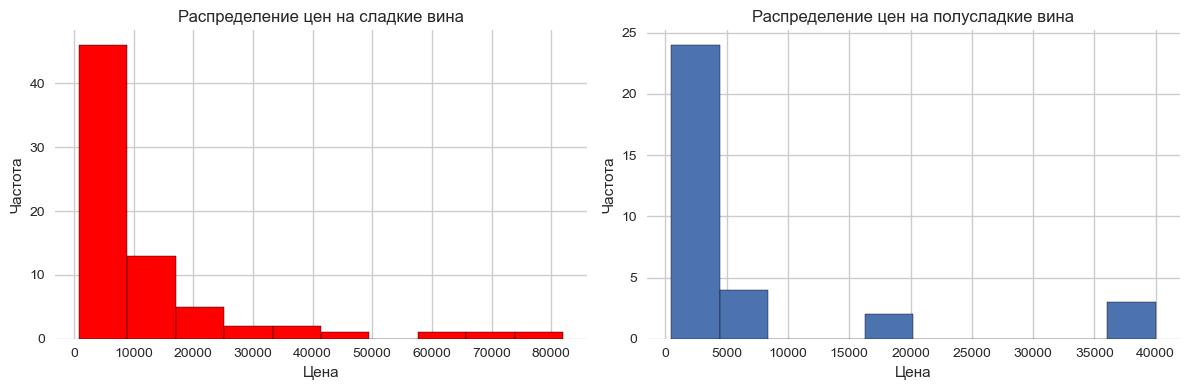

In [17]:
sweet_wine = df[df['sweetness'] == 'сладкое']['base_price']
semi_sweet_wine = df[df['sweetness'] == 'полусладкое']['base_price']

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

# Создаем гистограмму распределения для цен на сладкое вино
axes[0].hist(sweet_wine, bins=10, edgecolor='black', color='r')
axes[0].set_xlabel('Цена')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение цен на cладкие вина')

# Создаем гистограмму распределения для цен на полусладкое вино
axes[1].hist(semi_sweet_wine, bins=10, edgecolor='black')
axes[1].set_xlabel('Цена')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение цен на полусладкие вина')

plt.tight_layout()
plt.show()

__Сложно, зрительно оценив график, сделать вывод об "одинаковости" форм распределения групп сладких и полусладких вин. Данные в обеих выборках не следуют нормальному распределению, также в выборке полусладких вин мало наблюдений: 33, вследствие этого использую бустрап для оценки разности средних.__

В контексте теста на равенство средних, преимущество использования бутстрапа включает в себя то, что он может быть использован даже если распределение данных отличается от нормального, что делает его более универсальным и гибким, чем классические тесты. Также в выборке с полусладкими винами мало данных, статистические выводы могут быть ненадежными, особенно если нарушены предположения о нормальности или других распределениях. Бутстрап позволяет сгенерировать большое количество псевдо-выборок путем выбора с возвратом из исходной выборки.

_Общая нулевая гипотеза для бутстрап-тестов может быть сформулирована как отсутствие различий между двумя группами или выборками, а альтернативная гипотеза состоит в том, что различия есть. Если полученное p-значение меньше заданного уровня значимости (например, 0.05), то мы отвергаем нулевую гипотезу и приходим к выводу, что различия между группами статистически значимы._

__Нулевая гипотеза (H0):__ Средняя цена сладкого вина равна средней цене полусладкого вина.

__Альтернативная гипотеза (H1):__ Средняя цена сладкого вина больше средней цены полусладкого вина.

In [18]:
# Функция для создания бутстрап-выборки
def bootstrap_sample(data, n_bootstrap_samples=1000):
    return data.sample(n=n_bootstrap_samples, replace=True)

# Бутстрап
t_bootstrap_samples = []
for _ in range(1000):
    sweet_sample = bootstrap_sample(sweet_wine)
    semi_sweet_sample = bootstrap_sample(semi_sweet_wine)
    t_bootstrap_samples.append(sweet_sample.mean() - semi_sweet_sample.mean())

# 95% доверительный интервал
lower_bound = np.percentile(t_bootstrap_samples, 2.5)
upper_bound = np.percentile(t_bootstrap_samples, 97.5)

# Проверка гипотезы
if lower_bound > 0:
    print("Отверагем нулевую гипотезу, разность матожиданий sweet_wine и semi_sweet_wine не равна 0")
else:
    print("Не отверагаем нулевую гипотезу, разность матожиданий sweet_wine и semi_sweet_wine может быть равна 0")

Отверагем нулевую гипотезу, разность матожиданий sweet_wine и semi_sweet_wine не равна 0


__Нулевая гипотеза отвергается и можно считать, что средняя цена сладкого вина действительно больше средней цены полусладкого вина__

### Таким образом, сухое вино в среднем дороже, чем полусухое, а сладкое в среднем дороже, чем полусладкое

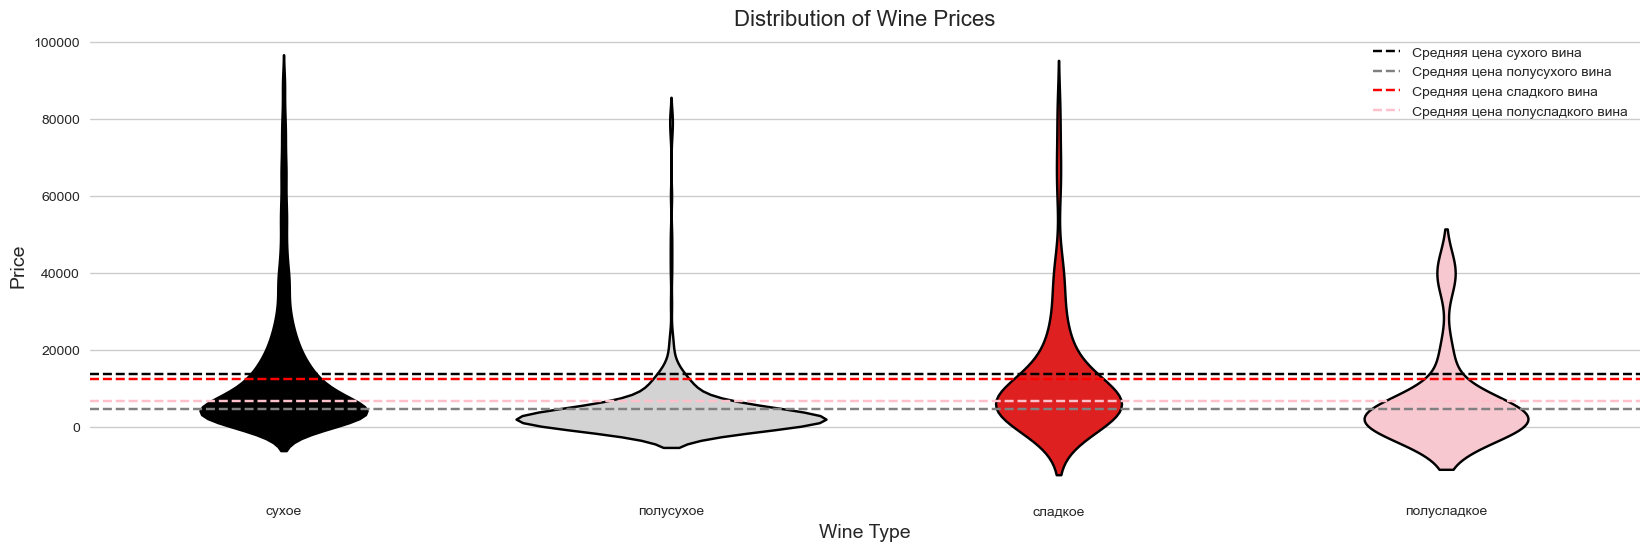

In [19]:
# Оставляем только интересующие нас типы вина
df_sweetness = df[df['sweetness'].isin(['сухое', 'полусухое', 'сладкое', 'полусладкое'])]

# Устанавливаем стиль и размеры
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
palette = {'сухое': 'black', 'полусухое': 'lightgray', 'сладкое': 'red', 'полусладкое': 'pink'}

# Построение скрипичного графика
sns.violinplot(x='sweetness', y='base_price', data=df_sweetness, order=['сухое', 'полусухое', 'сладкое', 'полусладкое'], inner=None, palette=palette)

# Построение линий средних для цен разных видов вина
plt.axhline(y=np.mean(dry_wine), linestyle='--', color='black', label='Средняя цена сухого вина')
plt.axhline(y=np.mean(semi_dry_wine), linestyle='--', color='grey', label='Средняя цена полусухого вина')
plt.axhline(y=np.mean(sweet_wine), linestyle='--', color='red', label='Средняя цена сладкого вина')
plt.axhline(y=np.mean(semi_sweet_wine), linestyle='--', color='pink', label='Средняя цена полусладкого вина')

plt.title('Distribution of Wine Prices', fontsize=16)
plt.xlabel('Wine Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='upper right')
plt.show()

# Гипотеза 7

Мы считаем, что сладость вина положительно коррелирует с рейтингом покупателей. Сформулируем гипотезу.

__Нулевая гипотеза (H0):__ сладость и рейтинг покупателей независимы

__Альтернативная гипотеза (H1):__ сладость коррелирует с рейтингом покупателей 

С помощью перестановочного теста проверим, говрит ли полученная выборочная корреляция о зависимости признаков.

In [20]:
#Переведем сладость в числа
sweet = list(df['sweetness'])
sweet_dict = {'сухое': 0, 'полусухое': 1, 'полусладкое': 2, 'сладкое': 3}
sweet_numbers = [sweet_dict[i] for i in sweet]

#Сделаем из оценок list
client_rating = list(df['client_rating'])

#Избавимся от пропусков
list1 = []
list2 = []
for i in range(len(sweet_numbers)):
    if np.isnan(np.array(client_rating))[i] == False:
        list1.append(sweet_numbers[i])
        list2.append(client_rating[i])
        
#Найдем выборочную корреляцию
corr = np.corrcoef(list1, list2)[0,1]

#Посчитаем корреляции после перестановки
corrs = []
for i in range(10000):
    list2_shuffled = random.sample(list2, len(list2))
    corr_shuffled = np.corrcoef(list1, list2_shuffled)[0,1]
    corrs.append(corr_shuffled)

#Построим доверительный интервал и проверим, входит ли в него наше значение корреляции
interval = [np.quantile(corrs,0.025), np.quantile(corrs,0.975)]
if interval[0] <= corr <= interval[1]:
    print('H0 не отвергается на уровне значимости 0.05')
else:
    print('H0 отвергается на уровне значимости 0.05')

#Вычислим p-value
p_value = np.mean(np.array(corrs)>corr)*2
print('P-value =', p_value)
print('Выборочная корреляция =', corr)
print('95% доверительный интервл -', interval)

H0 отвергается на уровне значимости 0.05
P-value = 0.0
Выборочная корреляция = 0.07742837193967088
95% доверительный интервл - [-0.03453552374668973, 0.033110902777234136]


_Нулевая гипотеза отвергается, следовательно, сладость и рейтинг покупателей зависимы._

__Таким образом, корреляция между сладостью и рейтингом покупателей положительна, но невелика, соответственно, клиенты при оценке вин учитывают сладость, но незначительно.__

Визуализируем гипотезу о том, критики иначе оценивают вина, чем обычные клиенты с помощью точечной диаграммы распределения

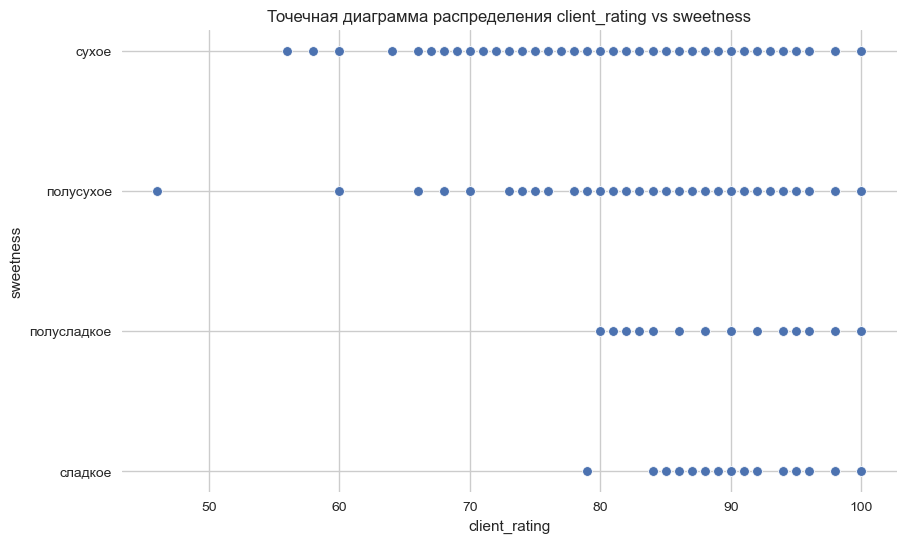

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(client_rating, sweet)
plt.title('Точечная диаграмма распределения client_rating vs sweetness')
plt.xlabel('client_rating')
plt.ylabel('sweetness')
plt.show()